# Adapting PI3NN Uncertainty Quantification to a model agnostic head based format

The original implemntation of PI3NN requires training three separate models to estimate the mean, upper bound, and lower bound,
of the confidence interval.  This attempts to wrap the those three models into a single model where all three values
can be obtained synchronously. We'll use the cubic example from the PI3NN publication (https://doi.org/10.48550/arXiv.2108.02327)
as a test case.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Define our model and the UQ head along with a custom loss function

In [9]:
### Define our target function

torch.set_default_tensor_type(torch.FloatTensor)
device = 'cpu'

def target_fun(x):
    noise = torch.randn(x.size(),device=device)
    # print(x.size(0))
    for i in range(x.size(0)):
        if(noise[i]>0):
            noise[i] = noise[i] * 10.0
        else:
            noise[i] = noise[i] * 2.0
    y = x**3 + noise
    return y

## Define a simple model to predict the target function
class UQ_Net_mean(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Create a head for predicting the upper and lower bounds, these values will then be
## scaled to achieve the desired confidence interval
class pi3nn_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,200)
        self.fc2 = nn.Linear(200,2)
        self.fc2.bias=torch.nn.Parameter(torch.tensor(10.0))

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.sqrt(torch.square(self.fc2(x)) + 1e-10)
        return x

## Wrap the main model with the head, you could theoretically swap out any main model here to train the confidence
## bounds synchronously
class UQ_Net_mean_wHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean_layer=UQ_Net_mean()
        self.head_layer=pi3nn_head()

    def forward(self,x):
        x=self.mean_layer(x)
        ci = self.head_layer(x)

        return x, ci

## Write a custom mse loss function that takes into account the main prediction plus the upper and lower bounds
## prediction
def mse_pi3nn(y_true, y_pred,ci,lambdas):
    error = y_pred-y_true
    mse = torch.mean(torch.square(error))
    zero_or_positive = torch.where(
            error < 0, torch.zeros_like(y_true), torch.abs(error)-ci[:,0]
        )
    zero_or_neg = torch.where(
            error > 0, torch.zeros_like(y_true), torch.abs(error)-ci[:,1]
        )
    num_pos = torch.count_nonzero(zero_or_positive)
    num_neg = torch.count_nonzero(zero_or_neg)

    mse_ci_low = torch.sum(torch.square(zero_or_neg))/num_neg
    mse_ci_high = torch.sum(torch.square(zero_or_positive))/num_pos
    #print(f"mse:{mse:.2f}, mse_low: {mse_ci_low:.2f}, mse_high = {mse_ci_high:.2f}")
    mse_loss = mse + lambdas*mse_ci_low + lambdas*mse_ci_high

    return mse_loss

## Generate the training dataset

In [10]:
# Generate dataset
Npar = 1
Ntrain = 1000
Nout = 1

xtrain = (torch.rand(Ntrain,Npar)*8.0-4.0).to(device)
ytrain = target_fun(xtrain).to(device)

x_mean = torch.mean(xtrain,axis=0)
x_std = torch.std(xtrain,axis=0)
xtrain_normal = (xtrain - x_mean)/x_std

y_mean = torch.mean(ytrain,axis=0)
y_std = torch.std(ytrain,axis=0)
ytrain_normal = (ytrain - y_mean)/y_std

Nvalid = 1000
xvalid = (torch.rand(Nvalid,Npar)*14.0-7.0).to(device)
yvalid = target_fun(xvalid).to(device)

xvalid_normal = (xvalid - x_mean) / x_std
yvalid_normal = (yvalid - y_mean) / y_std

## Train the model

In [11]:
# The network for estimating mean
net = UQ_Net_mean_wHead().to(device)
net.zero_grad()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Max_iter = 4000

for i in range(Max_iter):
    optimizer.zero_grad()
    output, ci_pred = net(xtrain_normal)
    loss = mse_pi3nn(output, ytrain_normal,ci_pred, 1)

    if i%500==0: print(i,loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 5)
    optimizer.step()

0 tensor(173.0298, grad_fn=<AddBackward0>)
500 tensor(0.2831, grad_fn=<AddBackward0>)
1000 tensor(0.1999, grad_fn=<AddBackward0>)
1500 tensor(0.1684, grad_fn=<AddBackward0>)
2000 tensor(0.1592, grad_fn=<AddBackward0>)
2500 tensor(0.1536, grad_fn=<AddBackward0>)
3000 tensor(0.1657, grad_fn=<AddBackward0>)
3500 tensor(0.1577, grad_fn=<AddBackward0>)


## Define our desired UQ percentile and scale the upper and lower bounds

1, f0: 407, f1: -43, f2: -43
2, f0: 407, f1: -5, f2: -5
3, f0: 125, f1: -5, f2: 125
4, f0: 50, f1: -5, f2: 50
5, f0: 12, f1: -5, f2: 12
6, f0: 4, f1: -5, f2: 4
7, f0: 1, f1: -5, f2: 1
8, f0: 1, f1: -2, f2: -2
9, f0: 1, f1: -1, f2: -1
1, f0: 495, f1: -45, f2: -45
2, f0: 495, f1: -42, f2: -42
3, f0: 495, f1: -15, f2: -15
4, f0: 164, f1: -15, f2: 164
5, f0: 31, f1: -15, f2: 31
6, f0: 5, f1: -15, f2: 5
7, f0: 5, f1: -10, f2: -10
8, f0: 5, f1: -3, f2: -3
9, f0: 1, f1: -3, f2: 1
10, f0: 1, f1: -1, f2: -1


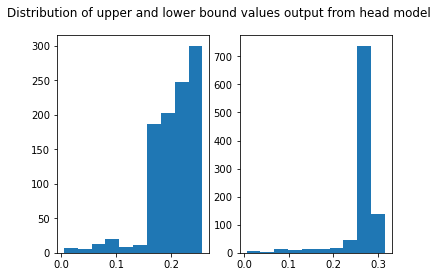

In [12]:
# Target percentile
quantile = 0.9

num_outlier = int(Ntrain * (1-quantile)/2)
net.eval()
with torch.no_grad():
    output, ci = net(xtrain_normal)

output_up = ci[:,0].unsqueeze(dim=1)
output_down = ci[:,1].unsqueeze(dim=1)

fig, axes = plt.subplots(1,2)
axes[0].hist(output_down.detach().cpu().numpy())
axes[1].hist(output_up.detach().cpu().numpy())
fig.suptitle("Distribution of upper and lower bound values output from head model")

### Scale the upper bound
c_up0 = 0.0
c_up1 = 10.0

f0 = (ytrain_normal >= output + c_up0 * output_up).sum() - num_outlier
f1 = (ytrain_normal >= output + c_up1 * output_up).sum() - num_outlier

n_iter = 1000
iter = 0
while iter <= n_iter and f0*f1<0:  ##f0 != 0 and f1 != 0:

    c_up2 = (c_up0 + c_up1)/2.0
    f2 = (ytrain_normal >= output + c_up2 * output_up).sum() - num_outlier

    if f2 == 0:
        break
    elif f2 > 0:
        c_up0 = c_up2
        f0 = f2
    else:
        c_up1 = c_up2
        f1 = f2
    iter +=1
    print('{}, f0: {}, f1: {}, f2: {}'.format(iter, f0, f1, f2))

c_up = c_up2

### Scale the lower bound
c_down0 = 0.0
c_down1 = 10.0

f0 = (ytrain_normal <= output - c_down0 * output_down).sum() - num_outlier
f1 = (ytrain_normal <= output - c_down1 * output_down).sum() - num_outlier

n_iter = 1000
iter = 0
while iter <= n_iter and f0*f1<0:  ##f0 != 0 and f1 != 0:

    c_down2 = (c_down0 + c_down1)/2.0
    f2 = (ytrain_normal <= output - c_down2 * output_down).sum() - num_outlier

    if f2 == 0:
        break
    elif f2 > 0:
        c_down0 = c_down2
        f0 = f2
    else:
        c_down1 = c_down2
        f1 = f2
    iter +=1
    print('{}, f0: {}, f1: {}, f2: {}'.format(iter, f0, f1, f2))
c_down = c_down2

## Plot up the results

Text(0.5, 0.98, 'PI3(1)NN with Head Results')

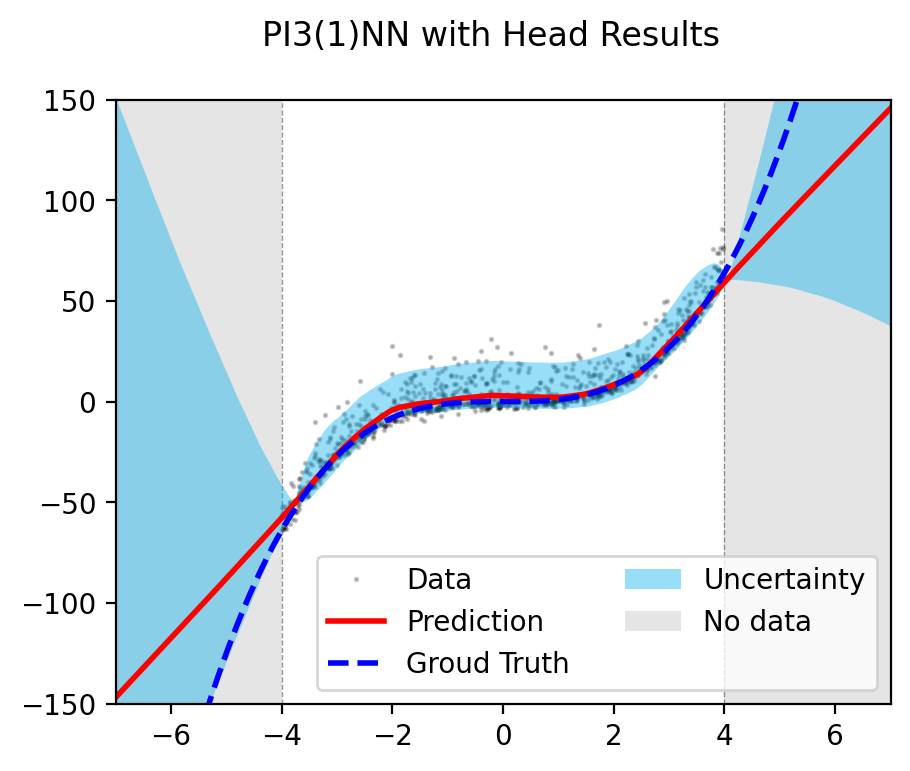

In [13]:
#------------------------------------------------------
# Plotting
x_plot = (torch.linspace(-7,7,steps=500).unsqueeze(1) - x_mean)/x_std

with torch.no_grad():
    y_plot_mean, ci = net(x_plot)

y_plot_up = ci[:,0].unsqueeze(dim=1)
y_plot_down = ci[:,1].unsqueeze(dim=1)

plt.figure(figsize=(5, 4), dpi=200)
plt.plot(xtrain.cpu().numpy(), ytrain.cpu().numpy(),'k.',markersize=2, alpha=0.2, zorder=0, label='Data')
plt.plot((x_plot*x_std+x_mean).cpu().numpy(), (y_plot_mean*y_std+y_mean).cpu().detach().numpy(), 'r', linewidth=2,label='Prediction')
plt.plot((x_plot*x_std+x_mean).cpu().numpy(), ((x_plot*x_std+x_mean)**3).cpu().numpy(),'b--',linewidth=2,label='Groud Truth')
plt.fill_between((x_plot*x_std+x_mean).cpu().numpy().squeeze(),
            ((y_plot_mean-c_down*y_plot_down)*y_std+y_mean).cpu().detach().numpy().squeeze(),
            ((y_plot_mean+c_up  *y_plot_up  )*y_std+y_mean).cpu().detach().numpy().squeeze(),
            alpha=0.4,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Uncertainty")
plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, linewidth=0.5, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, linewidth=0.5, zorder=0)
plt.fill_between([-7, -4],[-150, -150], [150, 150],edgecolor=None,facecolor='k',alpha=0.1, zorder=0,label='No data')
plt.fill_between([4, 7],[-150, -150], [150, 150],edgecolor=None,facecolor='k',alpha=0.1, zorder=0)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.legend(loc="lower right",ncol=2)
plt.suptitle('PI3(1)NN with Head Results')

## We can compare these results to the 3 model original implementation

0 tensor(0.9175, grad_fn=<MseLossBackward0>)
1000 tensor(0.0755, grad_fn=<MseLossBackward0>)
2000 tensor(0.0716, grad_fn=<MseLossBackward0>)
3000 tensor(0.0701, grad_fn=<MseLossBackward0>)
0 tensor(225.5883, grad_fn=<MseLossBackward0>)
1000 tensor(0.0625, grad_fn=<MseLossBackward0>)
2000 tensor(0.0616, grad_fn=<MseLossBackward0>)
3000 tensor(0.0612, grad_fn=<MseLossBackward0>)
0 tensor(222.8484, grad_fn=<MseLossBackward0>)
1000 tensor(0.0063, grad_fn=<MseLossBackward0>)
2000 tensor(0.0056, grad_fn=<MseLossBackward0>)
3000 tensor(0.0056, grad_fn=<MseLossBackward0>)
0, f0: 298, f1: -26, f2: -26
0, f0: 298, f1: -2, f2: -2
0, f0: 88, f1: -2, f2: 88
0, f0: 28, f1: -2, f2: 28
0, f0: 10, f1: -2, f2: 10
0, f0: 6, f1: -2, f2: 6
0, f0: 4, f1: -2, f2: 4
0, f0: 1, f1: -2, f2: 1
0, f0: 1, f1: -2, f2: -2
0, f0: 604, f1: -34, f2: -34
0, f0: 604, f1: -19, f2: -19
0, f0: 151, f1: -19, f2: 151
0, f0: 1, f1: -19, f2: 1
0, f0: 1, f1: -11, f2: -11
0, f0: 1, f1: -3, f2: -3


Text(0.5, 0.98, 'Original PI3NN Results')

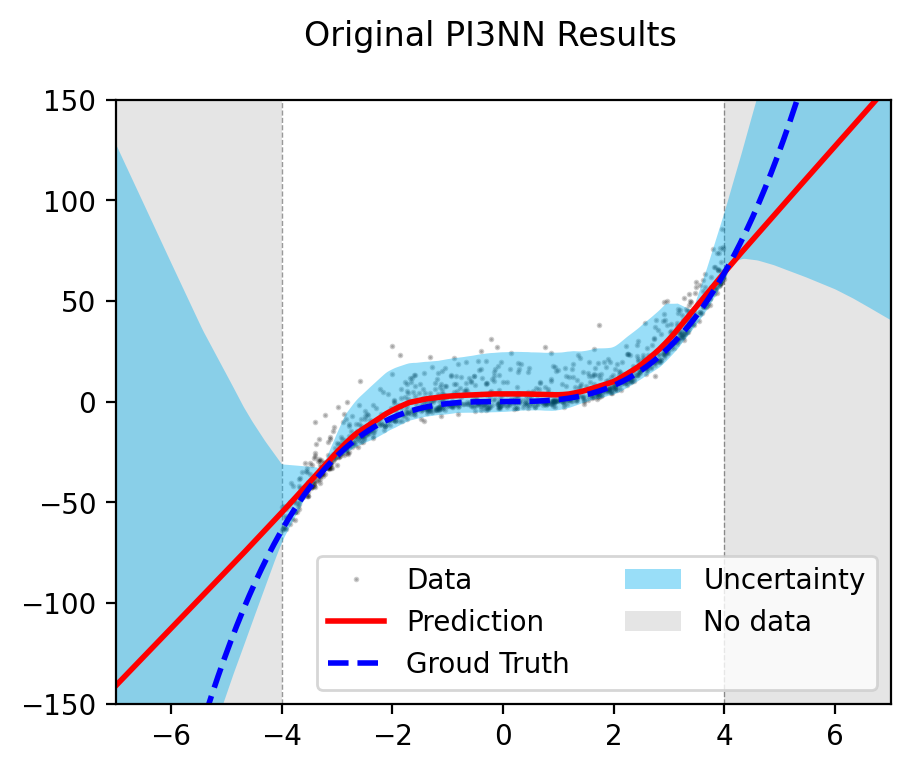

In [14]:
## Original upper and lower bound function
class UQ_Net_std(nn.Module):

    def __init__(self):
        super(UQ_Net_std, self).__init__()
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 1)
        self.fc2.bias = torch.nn.Parameter(torch.tensor([15.0]))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sqrt(torch.square(self.fc2(x)) + 1e-10)

        return x

    def UQ_loss(self, x, output, ydata):
        loss = torch.mean((output[:, 0] - ydata[:, 0]) ** 2)

        return loss

criterion = nn.MSELoss()

# The network for estimating mean
net = UQ_Net_mean().to(device)
net.zero_grad()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Max_iter = 4000

for i in range(Max_iter):

    optimizer.zero_grad()

    output = net(xtrain_normal)
    loss = criterion(output, ytrain_normal)

    if i % 1000 == 0: print(i, loss)

    loss.backward()

    optimizer.step()

# Generate difference data
diff = (ytrain_normal - net(xtrain_normal)).detach()

y_up_data = diff[diff > 0].unsqueeze(1)
x_up_data = xtrain_normal[diff > 0].unsqueeze(1)

y_down_data = -1.0 * diff[diff < 0].unsqueeze(1)
x_down_data = xtrain_normal[diff < 0].unsqueeze(1)

net_up = UQ_Net_std().to(device)
net_up.zero_grad()
optimizer = optim.SGD(net_up.parameters(), lr=0.01)

for i in range(Max_iter):
    optimizer.zero_grad()
    output = net_up(x_up_data)
    loss = criterion(output, y_up_data)
    # loss = net_up.UQ_loss(x_up_data, output, y_up_data)

    if torch.isnan(loss):
        print(output, y_up_data)
        exit()

    if i % 1000 == 0: print(i, loss)

    loss.backward()
    optimizer.step()

net_down = UQ_Net_std().to(device)
net_down.zero_grad()
optimizer = optim.SGD(net_down.parameters(), lr=0.01)

for i in range(Max_iter):
    optimizer.zero_grad()
    output = net_down(x_down_data)
    # loss = net_up.UQ_loss(x_down_data, output, y_down_data)
    loss = criterion(output, y_down_data)

    if torch.isnan(loss):
        print(output, y_down_data)
        exit()

    if i % 1000 == 0: print(i, loss)

    loss.backward()
    optimizer.step()

# ------------------------------------------------------
# Determine how to move the upper and lower bounds
num_outlier = int(Ntrain * (1 - quantile) / 2)

output = net(xtrain_normal)
output_up = net_up(xtrain_normal)
output_down = net_down(xtrain_normal)

c_up0 = 0.0
c_up1 = 10.0

f0 = (ytrain_normal >= output + c_up0 * output_up).sum() - num_outlier
f1 = (ytrain_normal >= output + c_up1 * output_up).sum() - num_outlier

n_iter = 1000
iter = 0
while iter <= n_iter and f0 * f1 < 0:  ##f0 != 0 and f1 != 0:

    c_up2 = (c_up0 + c_up1) / 2.0
    f2 = (ytrain_normal >= output + c_up2 * output_up).sum() - num_outlier

    if f2 == 0:
        break
    elif f2 > 0:
        c_up0 = c_up2
        f0 = f2
    else:
        c_up1 = c_up2
        f1 = f2
    print('{}, f0: {}, f1: {}, f2: {}'.format(iter, f0, f1, f2))

c_up = c_up2

c_down0 = 0.0
c_down1 = 10.0

f0 = (ytrain_normal <= output - c_down0 * output_down).sum() - num_outlier
f1 = (ytrain_normal <= output - c_down1 * output_down).sum() - num_outlier

n_iter = 1000
iter = 0
while iter <= n_iter and f0 * f1 < 0:  ##f0 != 0 and f1 != 0:

    c_down2 = (c_down0 + c_down1) / 2.0
    f2 = (ytrain_normal <= output - c_down2 * output_down).sum() - num_outlier

    if f2 == 0:
        break
    elif f2 > 0:
        c_down0 = c_down2
        f0 = f2
    else:
        c_down1 = c_down2
        f1 = f2
    print('{}, f0: {}, f1: {}, f2: {}'.format(iter, f0, f1, f2))
c_down = c_down2

# ------------------------------------------------------

# Plotting
x_plot = (torch.linspace(-7, 7, steps=500).unsqueeze(1) - x_mean) / x_std
y_plot_mean = net(x_plot)
y_plot_up = net_up(x_plot)
y_plot_down = net_down(x_plot)

plt.figure(figsize=(5, 4), dpi=200)
plt.plot(xtrain.cpu().numpy(), ytrain.cpu().numpy(), 'k.', markersize=2, alpha=0.2, zorder=0, label='Data')
plt.plot((x_plot * x_std + x_mean).cpu().numpy(), (y_plot_mean * y_std + y_mean).cpu().detach().numpy(), 'r',
         linewidth=2, label='Prediction')
# plt.plot((x_plot*x_std+x_mean).cpu().numpy(), ((y_plot_mean+c_up  *y_plot_up  )*y_std+y_mean).cpu().detach().numpy(), 'g--',linewidth=2)
# plt.plot((x_plot*x_std+x_mean).cpu().numpy(), ((y_plot_mean-c_down*y_plot_down)*y_std+y_mean).cpu().detach().numpy(), 'y--',linewidth=2)
plt.plot((x_plot * x_std + x_mean).cpu().numpy(), ((x_plot * x_std + x_mean) ** 3).cpu().numpy(), 'b--', linewidth=2,
         label='Groud Truth')
plt.fill_between((x_plot * x_std + x_mean).cpu().numpy().squeeze(),
                 ((y_plot_mean - c_down * y_plot_down) * y_std + y_mean).cpu().detach().numpy().squeeze(),
                 ((y_plot_mean + c_up * y_plot_up) * y_std + y_mean).cpu().detach().numpy().squeeze(),
                 alpha=0.4,
                 edgecolor=None,
                 facecolor='#00aeef',
                 linewidth=0,
                 zorder=1,
                 label="Uncertainty")
plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, linewidth=0.5, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, linewidth=0.5, zorder=0)
plt.fill_between([-7, -4], [-150, -150], [150, 150], edgecolor=None, facecolor='k', alpha=0.1, zorder=0,
                 label='No data')
plt.fill_between([4, 7], [-150, -150], [150, 150], edgecolor=None, facecolor='k', alpha=0.1, zorder=0)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.legend(loc="lower right", ncol=2)
plt.suptitle('Original PI3NN Results')